# Contract plans classification 


运营商竞赛主页：https://www.datafountain.cn/competitions/311/details/data-evaluation

csdn用户分享该竞赛的处理方法：https://blog.csdn.net/sjz_hahalala479/article/details/82878183

This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of five-class—classification, an important and widely applicable kind of machine learning problem. 


This notebook uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow. For a more advanced text classification tutorial using `tf.keras`, see the [MLCC Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification/).

In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.11.0


## Get the dataset

如果不在线读取csv文件，需要在左边栏文件选项卡处，上传csv格式的数据

如果从谷歌云盘存取文件的话，参考链接https://www.jianshu.com/p/d7283bc427b1           https://blog.csdn.net/popoffpopoff/article/details/81942023

In [0]:
# upload datas.csv first
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import  OneHotEncoder

#data = pd.read_csv("datas.csv") # https://www.cnblogs.com/guochangyu/p/7788414.html
data = pd.read_csv("https://github.com/zefang/Mobile-carrier-competition/raw/master/datas.csv") # read online data https://blog.csdn.net/Maverick_7/article/details/79026887
#data.head()
test_data = pd.read_csv("https://github.com/never770/mobile/raw/master/test_datas.csv")
test_data = test_data.drop(['user_id'], axis=1) #Xnew = predict_data.iloc[:, 2:(predict_data.shape[1])].as_matrix()
for test_column_name in test_data.columns:
  test_column = test_data[test_column_name]
  train_column = data[test_column_name]
  train_column_list = (train_column<=np.max(test_column)).tolist() and (train_column>=np.min(test_column)).tolist()
  data = data[train_column_list]

#x,y = data.drop(['user_id','current_service','service_type'], axis=1).as_matrix(),data.loc[:,'service_type'].as_matrix() # https://blog.csdn.net/sinat_29957455/article/details/79477940
#x,y = data.drop(['user_id','current_service','service_type','is_mix_service','many_over_bill','contract_type','is_promise_low_consume','net_service','complaint_level','gender'], axis=1).as_matrix(),data.loc[:,'current_service'].as_matrix() # https://blog.csdn.net/sinat_29957455/article/details/79477940
x,y = data.drop(['user_id','current_service'], axis=1).as_matrix(),data.loc[:,'current_service'].as_matrix() 

#enc = OneHotEncoder(sparse=False,categorical_features = [17,18,19,20,21,22,23,24])
#enc.fit(x)
#x = enc.transform(x)

# change gender to onehot
#x = np.column_stack((x[:,:-1],x[:,:-1]-1))

class_label = LabelEncoder() # https://blog.csdn.net/sinat_29957455/article/details/79452141
y = class_label.fit_transform(y)
train_data, test_data, train_labels, test_labels = train_test_split(x,y,test_size=0.2,random_state=0)

## Explore the data 

Let's take a moment to understand the format of the data. The dataset comes preprocessed: each example is an array of integers representing the words of the movie review. Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 594288, labels: 594288


The text of reviews have been converted to integers, where each integer represents a specific word in a dictionary. Here's what the first review looks like:

In [4]:
print(train_data[0])

[2.78892427e+03 3.60000000e+01 5.10000000e+01 6.04000000e+01
 4.60000000e+01 3.00000000e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.40000000e+01
 3.00000000e+01 1.00000000e+00 0.00000000e+00 1.24316667e+02
 9.78582849e+01 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.00000000e+00 0.00000000e+00
 1.00000000e+00]


Movie reviews may be different lengths. The below code shows the number of words in the first and second reviews. Since inputs to a neural network must be the same length, we'll need to resolve this later.

In [5]:
len(train_data[0]), len(train_data[1])

(25, 25)

## Build the model

The neural network is created by stacking layers—this requires two main architectural decisions:

* How many layers to use in the model?
* How many *hidden units* to use for each layer?

In this example, the input data consists of an array of word-indices. The labels to predict are either 0 or 1. Let's build a model for this problem:

模型参考链接：https://github.com/entron/entity-embedding-rossmann/tree/kaggle

In [6]:
# 'service_type','is_mix_service','many_over_bill','contract_type','is_promise_low_consume','net_service','complaint_level','gender'

input_continue_array = keras.layers.Input(shape=(len(train_data[0])-8,))

input_service_type = keras.layers.Input(shape=(1,))
output_service_type = keras.layers.Embedding(5,4)(input_service_type)
output_service_type = keras.layers.Reshape(target_shape=(4,))(output_service_type)

input_mix_service = keras.layers.Input(shape=(1,))

input_over_bill = keras.layers.Input(shape=(1,))

input_contract_type = keras.layers.Input(shape=(1,))
output_contract_type = keras.layers.Embedding(13,7)(input_contract_type)
output_contract_type = keras.layers.Reshape(target_shape=(7,))(output_contract_type)

input_low_consume = keras.layers.Input(shape=(1,))

input_net_service = keras.layers.Input(shape=(1,))
output_net_service = keras.layers.Embedding(10,5)(input_net_service)
output_net_service = keras.layers.Reshape(target_shape=(5,))(output_net_service)

input_complaint_level = keras.layers.Input(shape=(1,))

input_gender = keras.layers.Input(shape=(1,))

input_model = [input_continue_array, input_service_type, input_mix_service, input_over_bill, input_contract_type, input_low_consume, input_net_service, input_complaint_level, input_gender]
output_embeding = [input_continue_array, output_service_type, input_mix_service, input_over_bill, output_contract_type, input_low_consume, output_net_service, input_complaint_level, input_gender]
output_model = keras.layers.Concatenate()(output_embeding)
output_model = keras.layers.BatchNormalization()(output_model)
#output_model = keras.layers.Dropout(0.05)(output_model)
output_model = keras.layers.Dense(64, activation=tf.nn.relu)(output_model)
output_model = keras.layers.BatchNormalization()(output_model)

# Residual Unit https://blog.csdn.net/loveliuzz/article/details/79117397
output_model_shortcut = output_model
output_model = keras.layers.Dense(64, activation=tf.nn.relu)(output_model)
#output_model = keras.layers.Dropout(0.05)(output_model)
output_model = keras.layers.Dense(64)(output_model)
output_model = keras.layers.BatchNormalization()(output_model)
output_model = keras.layers.add([output_model_shortcut,output_model])
output_model = keras.layers.Activation("relu")(output_model)

# Residual Unit
output_model_shortcut = output_model
output_model = keras.layers.Dense(64, activation=tf.nn.relu)(output_model)
#output_model = keras.layers.Dropout(0.05)(output_model)
output_model = keras.layers.Dense(64)(output_model)
output_model = keras.layers.BatchNormalization()(output_model)
output_model = keras.layers.add([output_model_shortcut,output_model])
output_model = keras.layers.Activation("relu")(output_model)

output_model = keras.layers.Dense(128, activation=tf.nn.relu)(output_model)

output_model = keras.layers.Dense(11, activation=tf.nn.sigmoid)(output_model)

model = keras.models.Model(inputs=input_model, outputs=output_model)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 4)         20          input_2[0][0]                    
__________________________________________________________________________________________________
embedding_

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model can handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.
4. The last layer is densely connected with a single output node. Using the `sigmoid` activation function, this value is a float between 0 and 1, representing a probability, or confidence level.

### Hidden units

The above model has two intermediate or "hidden" layers, between the input and output. The number of outputs (units, nodes, or neurons) is the dimension of the representational space for the layer. In other words, the amount of freedom the network is allowed when learning an internal representation.

If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, it makes the network more computationally expensive and may lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data. This is called *overfitting*, and we'll explore it later.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs of a probability (a single-unit layer with a sigmoid activation), we'll use the `binary_crossentropy` loss function. 

This isn't the only choice for a loss function, you could, for instance, choose `mean_squared_error`. But, generally, `binary_crossentropy` is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Later, when we are exploring regression problems (say, to predict the price of a house), we will see how to use another loss function called mean squared error.

Now, configure the model to use an optimizer and a loss function:

In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Create a validation set

When training, we want to check the accuracy of the model on data it hasn't seen before. Create a *validation set* by setting apart 10,000 examples from the original training data. (Why not use the testing set now? Our goal is to develop and tune our model using only the training data, then use the test data just once to evaluate our accuracy).

In [0]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## Train the model

Train the model for 40 epochs in mini-batches of 512 samples. This is 40 iterations over all samples in the `x_train` and `y_train` tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [0]:
def split_features(X):
    X_list = []

    store_index = X[..., :-8]
    X_list.append(store_index)
    
    day_of_week = X[..., [-8]]
    X_list.append(day_of_week)

    promo = X[..., [-7]]
    X_list.append(promo)
    
    day_of_week = X[..., [-6]]
    X_list.append(day_of_week)

    promo = X[..., [-5]]
    X_list.append(promo)

    year = X[..., [-4]]
    X_list.append(year)

    month = X[..., [-3]]
    X_list.append(month)

    day = X[..., [-2]]
    X_list.append(day)

    State = X[..., [-1]] # change gender to onehot 
    X_list.append(State)

    return X_list

In [0]:
history = model.fit(split_features(partial_x_train),
                    partial_y_train,
                    epochs=6000,
                    batch_size=256,
                    validation_data=([split_features(x_val), y_val]),
                    verbose=1)

Train on 584288 samples, validate on 10000 samples
Epoch 1/6000
584288/584288 [==============================] - 20s 34us/step - loss: 0.4939 - acc: 0.8087 - val_loss: 0.3705 - val_acc: 0.8552
Epoch 2/6000
584288/584288 [==============================] - 19s 32us/step - loss: 0.3772 - acc: 0.8534 - val_loss: 0.3383 - val_acc: 0.8699
Epoch 3/6000
584288/584288 [==============================] - 19s 32us/step - loss: 0.3473 - acc: 0.8653 - val_loss: 0.3242 - val_acc: 0.8783
Epoch 4/6000
584288/584288 [==============================] - 19s 32us/step - loss: 0.3303 - acc: 0.8724 - val_loss: 0.3204 - val_acc: 0.8726
Epoch 5/6000
584288/584288 [==============================] - 19s 33us/step - loss: 0.3178 - acc: 0.8773 - val_loss: 0.2982 - val_acc: 0.8834
Epoch 6/6000
584288/584288 [==============================] - 19s 33us/step - loss: 0.3085 - acc: 0.8811 - val_loss: 0.2807 - val_acc: 0.8928
Epoch 7/6000
584288/584288 [==============================] - 19s 32us/step - loss: 0.3004 - acc:

# Save Model

保存模型参考链接：https://blog.csdn.net/LuohenYJ/article/details/81096886

In [5]:
model.save('model_embedding.h5')
model = tf.keras.models.load_model('model_embedding.h5')
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#results = new_model.evaluate(split_features(test_data), test_labels)
#print(results)

## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [12]:
#test_data = pd.read_csv("validation_data_modify.csv")
#test_data,test_labels = test_data.drop(['user_id','current_service'], axis=1).as_matrix(),test_data.loc[:,'current_service'].as_matrix() 
#test_labels = class_label.fit_transform(test_labels)

results = model.evaluate(split_features(test_data), test_labels)

print(results)

19998/19998 [==============================] - 1s 25us/step
[0.1853188443386873, 0.9262426242624262]


This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

## Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [37]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

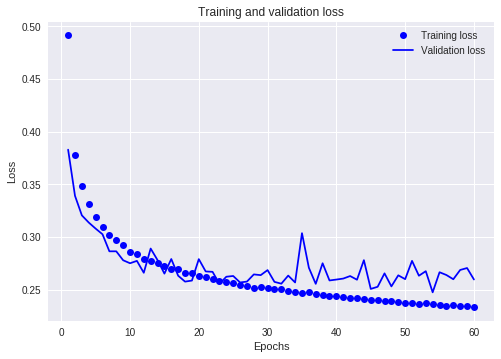

In [38]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

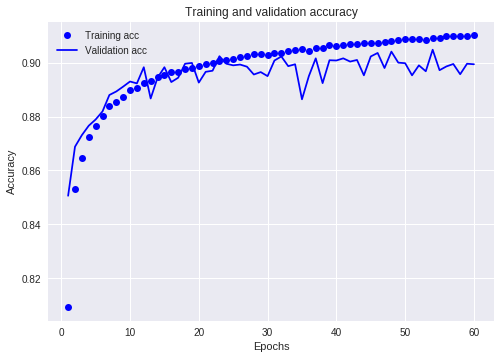

In [39]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.

## 提取倒数第一层的特征

In [38]:
model.layers[-2].name

'dense_12'

In [0]:
dense_layer_model = keras.models.Model(inputs=model.input,outputs=model.get_layer(model.layers[-2].name).output)
dense_output = dense_layer_model.predict(split_features(x))

In [51]:
dense_output.shape

(742861, 128)

In [43]:
dense_output_csv = pd.DataFrame(dense_output)
dense_output_csv.head()
dense_output_csv.to_csv('deep_features.csv', index=False)

y_label = class_label.inverse_transform(y)
y_label_csv = pd.DataFrame(y_label)
y_label_csv.to_csv('deep_feature_labels.csv', index=False)



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


上传文件到谷歌云盘

In [52]:
#保存文件
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Create & upload a text file.
#你想要导出的文件的名字
uploaded = drive.CreateFile({'title': 'deep_features_googledrive.csv'})
#改为之前生成文件的名字
uploaded.SetContentFile('deep_features.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1bYSZZA3F5Ey2rElD_07sNOgmTclonIHp


# Predict Label

How to predict https://blog.csdn.net/baimafujinji/article/details/78385745

In [41]:
predict_data = pd.read_csv("https://github.com/never770/mobile/raw/master/test_datas.csv")
#predict_data.head()

Xnew = predict_data.drop(['user_id'], axis=1).as_matrix() #Xnew = predict_data.iloc[:, 2:(predict_data.shape[1])].as_matrix()
#Xnew = np.column_stack((Xnew[:,:-1],Xnew[:,:-1]-1))

ynew = model.predict(split_features(Xnew))
ynew_arr = np.array(ynew)
label_tmp = np.argmax(ynew_arr,axis=1)
#label_proba = ynew_arr[label_tmp]

ynew_ = class_label.inverse_transform(label_tmp)
sub_filename=predict_data['user_id'].tolist()
submission = pd.DataFrame({'user_id':sub_filename, 'current_service':ynew_})
submission = submission[['user_id','current_service']]
submission.to_csv('submission.csv', index=False)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [0]:
y_predict = model.predict(split_features(x))
y_predict = np.array(y_predict)
y_label_predict = np.argmax(y_predict,axis=1)

In [0]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

Confusion matrix, without normalization
Normalized confusion matrix


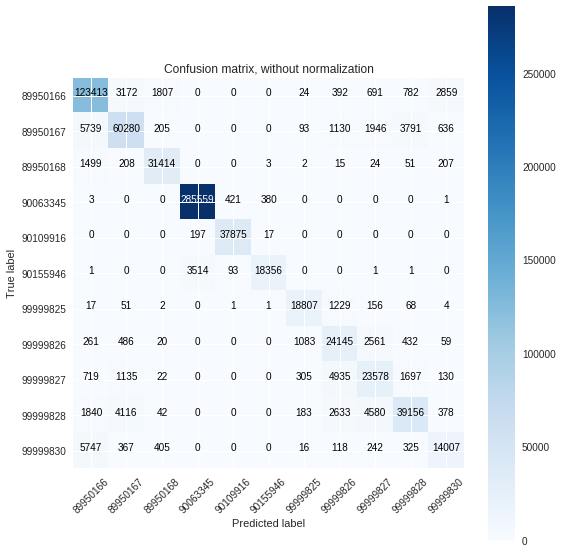

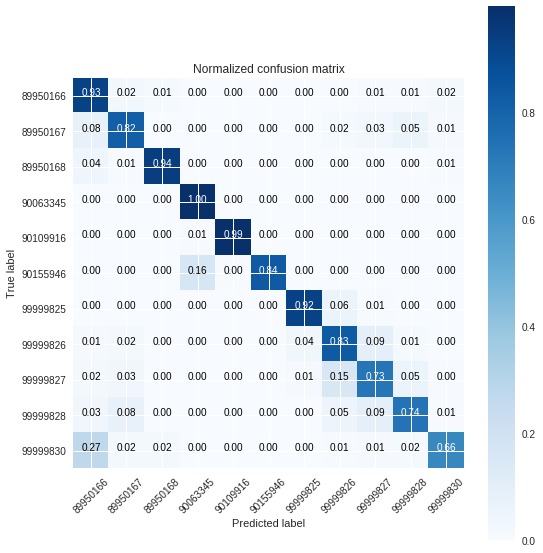

In [49]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y, y_label_predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=class_label.classes_,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=class_label.classes_, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

针对每个类别给出详细的准确率、召回率和F-值这三个参数和宏平均值，用来评价算法好坏 https://blog.csdn.net/akadiao/article/details/78788864

In [48]:
print(classification_report(y, y_label_predict, target_names=class_label.classes_.astype('str')))

             precision    recall  f1-score   support

   89950166       0.89      0.93      0.91    133140
   89950167       0.86      0.82      0.84     73820
   89950168       0.93      0.94      0.93     33423
   90063345       0.99      1.00      0.99    286364
   90109916       0.99      0.99      0.99     38089
   90155946       0.98      0.84      0.90     21966
   99999825       0.92      0.92      0.92     20336
   99999826       0.70      0.83      0.76     29047
   99999827       0.70      0.73      0.71     32521
   99999828       0.85      0.74      0.79     52928
   99999830       0.77      0.66      0.71     21227

avg / total       0.91      0.91      0.91    742861



In [76]:
hard_train_data = x[y_label_predict!=y]
hard_train_labels = y[y_label_predict!=y]
#print(np.unique(hard_train_labels))
#print(np.bincount(hard_train_labels))
#print(np.bincount(y))
len(hard_train_labels)
prob=y_predict[y_label_predict!=y]
print(prob)

[[4.7949199e-02 1.5433926e-02 3.5438400e-03 ... 4.1687760e-01
  5.2917826e-01 1.2017355e-01]
 [2.6423114e-03 2.3558596e-03 3.5411151e-05 ... 5.1202639e-03
  4.0581659e-03 8.6449413e-04]
 [5.4874516e-01 1.4818865e-01 4.9636392e-03 ... 6.1192882e-04
  6.7117810e-02 1.3104518e-02]
 ...
 [3.2603952e-01 1.0743314e-01 1.3764834e-04 ... 2.3921109e-07
  8.5756155e-06 1.1708571e-02]
 [1.3581942e-01 1.8009733e-01 3.8785290e-03 ... 8.8484041e-02
  1.2835729e-01 2.2650184e-01]
 [1.1619221e-01 1.1325046e-01 1.8114707e-04 ... 1.5452715e-03
  7.6938428e-02 1.2952482e-02]]


##保存分类出错的样本

In [0]:
error_data=data[y_label_predict!=y]
#error_data.head()
error_data.to_csv("error_data.csv")

In [0]:
import matplotlib.pyplot as plt

import seaborn as sns  # 可视化 https://www.cnblogs.com/gczr/p/6767175.html

%matplotlib inline



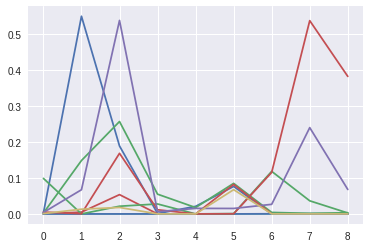

In [86]:
plt.plot(prob[1:10])

plt.show()

In [0]:
hard_predict = model.predict(split_features(hard_train_data))


In [45]:
prob = np.max(hard_predict,axis=1)
print(len(prob[prob>0.5]))


12473


##重新训练分类出错的样本

In [46]:
# 'service_type','is_mix_service','many_over_bill','contract_type','is_promise_low_consume','net_service','complaint_level','gender'

input_continue_array = keras.layers.Input(shape=(len(train_data[0])-8,))

input_service_type = keras.layers.Input(shape=(1,))
output_service_type = keras.layers.Embedding(5,4)(input_service_type)
output_service_type = keras.layers.Reshape(target_shape=(4,))(output_service_type)

input_mix_service = keras.layers.Input(shape=(1,))

input_over_bill = keras.layers.Input(shape=(1,))

input_contract_type = keras.layers.Input(shape=(1,))
output_contract_type = keras.layers.Embedding(13,7)(input_contract_type)
output_contract_type = keras.layers.Reshape(target_shape=(7,))(output_contract_type)

input_low_consume = keras.layers.Input(shape=(1,))

input_net_service = keras.layers.Input(shape=(1,))
output_net_service = keras.layers.Embedding(10,5)(input_net_service)
output_net_service = keras.layers.Reshape(target_shape=(5,))(output_net_service)

input_complaint_level = keras.layers.Input(shape=(1,))

input_gender = keras.layers.Input(shape=(1,))

input_model = [input_continue_array, input_service_type, input_mix_service, input_over_bill, input_contract_type, input_low_consume, input_net_service, input_complaint_level, input_gender]
output_embeding = [input_continue_array, output_service_type, input_mix_service, input_over_bill, output_contract_type, input_low_consume, output_net_service, input_complaint_level, input_gender]
output_model = keras.layers.Concatenate()(input_model)
output_model = keras.layers.BatchNormalization()(output_model)
#output_model = keras.layers.Dropout(0.05)(output_model)
output_model = keras.layers.Dense(500, activation=tf.nn.relu)(output_model)
output_model = keras.layers.BatchNormalization()(output_model)

output_model = keras.layers.Dense(128, activation=tf.nn.relu)(output_model)
output_model = keras.layers.BatchNormalization()(output_model)

output_model = keras.layers.Dense(11, activation=tf.nn.sigmoid)(output_model)

hard_model = keras.models.Model(inputs=input_model, outputs=output_model)

hard_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 17)           0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_23 (

In [47]:
hard_model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hard_train_data, hard_test_data, hard_train_labels, hard_test_labels = train_test_split(hard_train_data,hard_train_labels,test_size=0.2,random_state=0)

x_val = hard_train_data[:1000]
partial_x_train = hard_train_data[1000:]

y_val = hard_train_labels[:1000]
partial_y_train = hard_train_labels[1000:]

hard_history = hard_model.fit(split_features(partial_x_train),
                    partial_y_train,
                    epochs=60,
                    batch_size=256,
                    validation_data=([split_features(x_val), y_val]),
                    verbose=1)

Train on 52016 samples, validate on 1000 samples
Epoch 1/60
52016/52016 [==============================] - 3s 66us/step - loss: 1.6889 - acc: 0.3245 - val_loss: 1.5961 - val_acc: 0.3550
Epoch 2/60
52016/52016 [==============================] - 3s 51us/step - loss: 1.4339 - acc: 0.3705 - val_loss: 1.3896 - val_acc: 0.3750
Epoch 3/60
52016/52016 [==============================] - 3s 52us/step - loss: 1.3603 - acc: 0.3901 - val_loss: 1.3452 - val_acc: 0.3970
Epoch 4/60
52016/52016 [==============================] - 3s 51us/step - loss: 1.3072 - acc: 0.4209 - val_loss: 1.2906 - val_acc: 0.4250
Epoch 5/60
52016/52016 [==============================] - 3s 50us/step - loss: 1.2730 - acc: 0.4336 - val_loss: 1.2994 - val_acc: 0.4330
Epoch 6/60
52016/52016 [==============================] - 3s 51us/step - loss: 1.2504 - acc: 0.4438 - val_loss: 1.2960 - val_acc: 0.4280
Epoch 7/60
52016/52016 [==============================] - 3s 51us/step - loss: 1.2313 - acc: 0.4508 - val_loss: 1.2642 - val_acc:

In [48]:
results = hard_model.evaluate(split_features(hard_test_data), hard_test_labels)

print(results)

13255/13255 [==============================] - 1s 61us/step
[1.3634830422151407, 0.5004149377615845]


In [0]:
hard_predict = hard_model.predict(split_features(hard_train_data))
hard_predict = np.array(hard_predict)
hard_label_predict = np.argmax(hard_predict,axis=1)

In [64]:
prob = np.max(hard_predict,axis=1)
print(len(prob[prob>0.5]))

18432


In [71]:
hard_predict_true = hard_predict[hard_label_predict==hard_train_labels]
prob = np.max(hard_predict_true,axis=1)
print(len(prob))

37209


In [72]:
hard_predict_flase = hard_predict[hard_label_predict!=hard_train_labels]
prob = np.max(hard_predict_flase,axis=1)
print(len(prob))

15807
